# 1. 준비

### KoNLPy 에서 가장 성능이 준수한 MeCap 클래스를 활용해보자!

우분투 환경 설치

1. jdk 설치 `$ sudo apt-get install g++ openjdk-8-jdk`
2. MeCap 설치 `$ bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)`
3. konlpy 설치 `pip install konlpy` [KoNLPy 설치](https://konlpy.org/ko/latest/install/)

In [52]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


In [53]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

# 2. 데이터 다운로드 및 분석

In [54]:
# $ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
# $ mkdir -p ~/aiffel/sp_tokenizer/data
# $ mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
# $ cd ~/aiffel/sp_tokenizer/data
# $ tar -xzvf korean-english-park.train.tar.gz

In [55]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines() # raw에 데이터 담음

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen) # @질문!!

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터!   
위 데이터는 한국어-영어 병렬을이루는 말뭉치 (한국어 파트)
- https://github.com/jungyeul/korean-parallel-corpora 한국어 데이터 셋

이제 94123개의 문장들에서 길이가 어떤지 확인하자. 너무 길거나 짧은 outlier들을 제거하고 시각화하여 확인하자

In [56]:
min_len = 999 # 4
max_len = 0 # 10
sum_len = 0 # 14

for sen in raw:
    length = len(sen)
    if min_len > length : min_len = length # 최단 길이 업데이트
    if max_len < length: max_len = length # 최장 길이 업데이트
    sum_len += length # 문장 총 길이

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)
# 최대 길이만큼 row 행렬 생성

for sen in raw:
    sentence_length[len(sen)-1] += 1
    # 영행렬에 문장 길이들 별로 횟수 추가
    # 신박한 접근...
    
print(sentence_length)

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60
[   1   13   25  137   24  121   50   57   77  103 1761  781  148  720
  311  247  954  319 1611  898 2113  461  494  556  535  526  595  651
  746  708  779  741  796  797  853  891  986  991  929 1025 1084 1087
 1090 1159 1093 1170 1134 1150 1160 1212 1227 1289 1310 1315 1298 1222
 1332 1348 1255 1320 1288 1322 1324 1333 1255 1185 1195 1299 1195 1190
 1149 1129 1039 1115 1065 1071  943  991  985  935  932  911  819  814
  828  742  736  737  684  676  692  688  651  603  569  542  512  542
  475  449  438  423  429  391  366  342  320  274  290  267  251  252
  259  205  242  206  217  180  165  170  165  170  136  161  138  116
  103  123  112   69   82   93   71   97   60   60   67   72   53   60
   54   60   55   51   46   28   41   36   29   25   45   13   20   31
   30   24   23   33   25   15   17   26   14   17   11   17   19   17
    7   20    9   10    7    5    8    5    4    6    9    5   10    5
    9    3    5    4    3    1    3

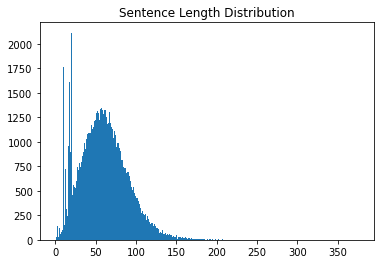

In [57]:
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [58]:
# 길이가 1인 문장이 뭐지?

def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw :
        if len(sen) == length :
            print(sen)
            count += 1
            if count > 100:
                return

check_sentence_with_length(raw, 1)

’


노이즈인 어퍼스트로피가 있었다!!! 확인해두자

In [59]:
for idx, _sum in enumerate(sentence_length) :
    # 문장의 수가 1500개를 초과하는 문장 길이 추출
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [60]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

과도하게 많이 사용된 문장을 보니 중복도 굉장히 많았다!!   
`set`을 이용해 중복 데이터를 제거해주자. list 순서가 섞이지 않도록 주의

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


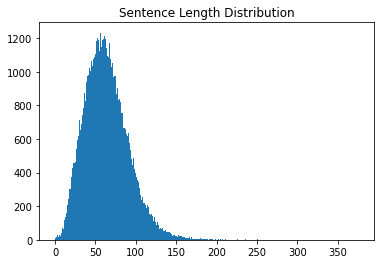

In [61]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set으로 중복을 제거 후 다시 리스트
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

중복 데이터를 제거하니 17000개 정도 줄어들었다

가장 긴 문장을 기준으로 **Padding**처리를 해야하나,   
`77591 X 377(문장 최장 길이)` 를 하게 되면 메모리 낭비가 너무 심하다.   
여기서는 길이 150 이상, 10 미만의 데이터는 제거하도록 한다

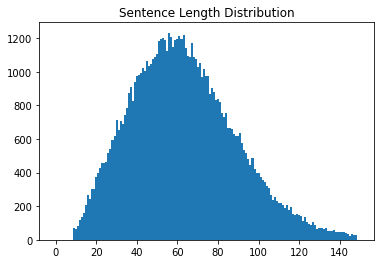

In [62]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

이제 지금부터 토큰화 시작하자!

# 3. 공백 기반 토큰화

위에서 정제된 데이터를 공백 기반으로 토큰화하여 list에 저장한 후, 아래 keras의 tokenize() 함수를 사용해 단어 사전과 Tensor 데이터를 얻자!   
그리고 단어 사전 크기를 확인

In [63]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus) # 문자를 리스트 형태로 변환
    
    # text를 숫자로 만들어진 시퀀스로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # padding='post' : padding을 문장들 뒤에 삽입
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [64]:
# 토큰화하여 시퀀스로 저장
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [65]:
# 단어사전

split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [66]:
split_corpus[1][1:12]

['사와야의', '작업공간은', '다양한', '색상들로', '폭탄을', '맞은듯', '하다.']

In [67]:
# word_index : 인덱스와 단어 딕셔너리 반환
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


- index_word 와 word_index 차이는 뭐지?

`밝혔다.`, `밝히다.` 또한 다른 단어로 분류될 수 있으므로 비효율적으로 큰 단어사전이 생겨 연상량을 증가시킬 수 있다.   
그렇다면 이것을 `밝 + 혔다`로 토큰화 한다면 의미를 파악하기 더욱 수월할 것이다.   
이를 위해 **형태소 분석기**가 있다!

# 4. 형태소 기반 토큰화

MeCab을 활용하여 형태소 기반 토큰화를 하자

In [68]:
from konlpy.tag import Mecab

mecab = Mecab()

mecab_corpus = [mecab.morphs(kor) for kor in filtered_corpus]

In [69]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))
print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

Split Vocab Size: 237435
MeCab Vocab Size: 52279


공백 기반 단어 사전에 비해 굉장히 많이 줄어들었다!   
연산량 감소로 더 빠르게 학습할 수 있고, 튜닝해야하는 매개변수도 줄어든다.   
즉, **한국어**를 처리할 때는 **공백 기반 토큰화를 지양**하자.

SentencePiece같은 Subword 기반 토큰화보다 형태소 분석기가 좋은 성능을 내는 사례들이 있다. 
https://aiopen.etri.re.kr/service_dataset.php   
그럼에도 SentencePiece 모델이 주목받는 이유는, 지속적으로 변화하고 생성되는 언어 데이터에 대한 OOV 문제에 대해서도 robust하게 대처할 수 있기 때문이다. 그리고 여러가지 언어가 섞이더라도 처리하기 좋다.   
어떤 언어에 특화된 토크나이저에 대체로 뒤지지 않거나 능가하기 때문.

지금까지는 문장을 Tensor로 Encoding을 했고,   
이번엔 모델이 생성한 Tensor를 문장으로 Decoding 해보자   

In [70]:
mecab_tensor[100]
# 이 문장을 Decoding 해보자

array([  115,  5233,  7519, 20711,    28,  8092,    27, 13233,    15,
        1035,    20,   115,  1830,   542,     6,   509,   105,     9,
        1028,    10,     4, 11438, 10736,     5,   749,    10,   163,
         196,  1118,    15,   667,    29,  1672,   180,  3021,   112,
           7,  7227,    17,   157,   310,  1440,   338,   630,     9,
        5600,    11,     2,     1,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [71]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

영국 브리티시 페트로 리엄 ( bp ) plc 가 파업 으로 영국 원유 생산 의 40 % 를 담당 하 는 북해 송유관 을 폐쇄 하 면서 국제 유가 가 28 일 배럴 당 120 달러 에 육박 , 또 다시 사상 최고 치 를 경신 했 다 .


In [72]:
# Case 2 : tokenizer.index_word

sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

영국 브리티시 페트로 리엄 ( bp ) plc 가 파업 으로 영국 원유 생산 의 40 % 를 담당 하 는 북해 송유관 을 폐쇄 하 면서 국제 유가 가 28 일 배럴 당 120 달러 에 육박 , 또 다시 사상 최고 치 를 경신 했 다 . 


# 5. 프로젝트 : SentencePiece 사용하여 네이버 영화리뷰 감성분석

## 1) SentencePeice 설치

[SentencePiece를 활용해 Vocab 만들기](https://paul-hyun.github.io/vocab-with-sentencepiece/)   
[SentencePiece 깃허브](https://github.com/google/sentencepiece)   
`$ pip install sentencepiece`   

## 2) SentencePiece 모델 학습

In [73]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [74]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 376892 Dec 14 01:40 korean_spm.model
-rw-r--r-- 1 root root 146388 Dec 14 01:40 korean_spm.vocab


위 코드를 통해 SentencePiece 모델 학습을 완료하고   
`korean_spm.model` 파일과 `korean_spm.vocab vocabulary` 파일이 생성된다.

In [75]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## 3) Tokenizer 함수 작성

보통 사용했던 토크나이저는 아니지만, SentencePiece를 통해 같은 역할로 만들어보자.

1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달한다.

2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환한다.

3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장이다. Padding까지 해준다.

In [76]:
def sp_tokenize(s, corpus):
    
    tensor = [s.EncodeAsIds(sen) for sen in corpus]
    
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        
        word_index.update({word:idx})
        index_word.update({idx:word})
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, word_index, index_word

In [77]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor[1])
print(index_word[54])

[ 107 1638  101    4    0  419   11    4   14    0 1969    3    3    3]
▁대한


## 4) 네이버 영화리뷰 데이터 준비

In [97]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import numpy as np

movie_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/nsmc'

 
train_data = pd.read_table(movie_path + '/ratings_train.txt')
test_data = pd.read_table(movie_path + '/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [98]:
print(f'length of train data : {len(train_data)}')
print(f'length of test data : {len(test_data)}')

length of train data : 150000
length of test data : 50000


### 전처리 및 데이터 로드

In [99]:
# 데이터 전처리 (중복, Null)

train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

In [100]:
# train, test data 모두 묶음

train_sen = train_data['document'].values.tolist()
all_sen = train_data['document'].values.tolist()
test_sen = test_data['document'].values.tolist()
all_sen.extend(test_sen)
print(f"train_sentence_len : {len(train_sen)}")
print(f"train_sentence_len : {len(test_sen)}")
print(f"train_sentence_len : {len(all_sen)}")

train_sentence_len : 146182
train_sentence_len : 49157
train_sentence_len : 195339


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


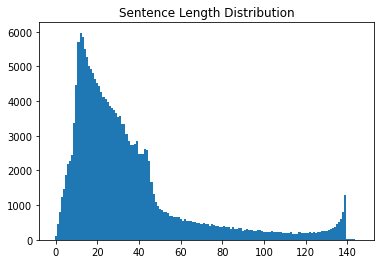

In [101]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(all_sen))  # set를 사용해서 중복을 다시 제거
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

평균 + 3표준편차로 최대길이 설정해보았지만, 너무 길이가 커서인지 학습이 잘 안되어 **100으로 설정**

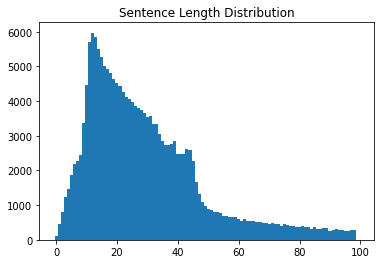

In [102]:
max_len = 100
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### SentencePiece 학습 (네이버 영화리뷰 train / test data)

Vocab_size = 8000

In [104]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # train, test data의 코퍼스 전부 학습
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_movie_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_movie_spm*

-rw-r--r-- 1 root root 375083 Dec 14 02:12 naver_movie_spm.model
-rw-r--r-- 1 root root 144530 Dec 14 02:12 naver_movie_spm.vocab


In [106]:
s = spm.SentencePieceProcessor()
s.Load('naver_movie_spm.model')

def sp_tokenize(s, corpus):
    
    tensor = [s.EncodeAsIds(sen) for sen in corpus]
    
    # with open("naver_movie_spm.vocab", 'r') as f:
    #      vocab = f.readlines()

    # word_index = {}
    # index_word = {}

    # for idx, line in enumerate(vocab):
    #     word = line.split("\t")[0]

    #     word_index.update({word:idx})
    #     index_word.update({idx:word})
    
    # tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor # word_index, index_word

In [107]:
def load_data(train_data, test_data):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    word_index = {}
    index_word = {}
    
    x_train = []        
    for sentence in train_data['document']:
        x_train.append(s.EncodeAsIds(sentence))
    
    x_test = []
    for sentence in test_data['document']:
        x_test.append(s.EncodeAsIds(sentence))

    with open("./naver_movie_spm.vocab", 'r') as f:
        vocab = f.readlines()

    # for idx, line in enumerate(vocab):
    #     word = line.split("\t")[0]

    #     word_index.update({idx:word})
    #     index_word.update({word:idx})

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post',maxlen=max_len)
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post',maxlen=max_len)
          
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_index, index_word

In [108]:
x_train, y_train, x_test, y_test, word_index, index_word = load_data(train_data, test_data)

In [109]:
x_train.shape

(146182, 100)

In [110]:
x_test.shape

(49157, 100)

# LSTM 학습 (unigram)

In [111]:
vocab_size = 8000    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
hidden_units = 256

#LSTM

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(hidden_units))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         800000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 1,168,149
Trainable params: 1,168,149
Non-trainable params: 0
_________________________________________________________________


In [112]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

history_model01 = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size= 512,
                    callbacks = es,
                    validation_split= 0.2,
                    verbose=1)

Epoch 1/5
229/229 [==============================] - 38s 156ms/step - loss: 0.5769 - accuracy: 0.6991 - val_loss: 0.3487 - val_accuracy: 0.8490
Epoch 2/5
229/229 [==============================] - 36s 158ms/step - loss: 0.3208 - accuracy: 0.8624 - val_loss: 0.3343 - val_accuracy: 0.8548
Epoch 3/5
229/229 [==============================] - 36s 156ms/step - loss: 0.2931 - accuracy: 0.8770 - val_loss: 0.3279 - val_accuracy: 0.8582
Epoch 4/5
229/229 [==============================] - 36s 157ms/step - loss: 0.2651 - accuracy: 0.8868 - val_loss: 0.3276 - val_accuracy: 0.8594
Epoch 5/5
229/229 [==============================] - 36s 157ms/step - loss: 0.2376 - accuracy: 0.9014 - val_loss: 0.3415 - val_accuracy: 0.8537


In [113]:
model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 18s - loss: 0.3502 - accuracy: 0.8503


[0.3502054810523987, 0.8502756357192993]

# LSTM (bpe)

In [122]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # train, test data의 코퍼스 전부 학습
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_movie_spm_bpe --vocab_size={} --model_type={}'.format(temp_file, vocab_size, 'bpe')    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_movie_spm_bpe*

-rw-r--r-- 1 root root 370599 Dec 14 02:31 naver_movie_spm_bpe.model
-rw-r--r-- 1 root root 115824 Dec 14 02:31 naver_movie_spm_bpe.vocab


In [123]:
def load_data(train_data, test_data):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    word_index = {}
    index_word = {}
    
    x_train = []        
    for sentence in train_data['document']:
        x_train.append(s.EncodeAsIds(sentence))
    
    x_test = []
    for sentence in test_data['document']:
        x_test.append(s.EncodeAsIds(sentence))

    with open("./naver_movie_spm_bpe.vocab", 'r') as f:
        vocab = f.readlines()

    # for idx, line in enumerate(vocab):
    #     word = line.split("\t")[0]

    #     word_index.update({idx:word})
    #     index_word.update({word:idx})

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post',maxlen=max_len)
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post',maxlen=max_len)
          
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_index, index_word

In [124]:
x_train, y_train, x_test, y_test, word_index, index_word = load_data(train_data, test_data)

In [125]:
print(x_train.shape)
print(x_test.shape)

(146182, 100)
(49157, 100)


In [126]:
vocab_size = 8000    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
hidden_units = 256

#LSTM

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(hidden_units))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         800000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,168,149
Trainable params: 1,168,149
Non-trainable params: 0
_________________________________________________________________


In [127]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

history_model02 = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size= 512,
                    callbacks = es,
                    validation_split= 0.2,
                    verbose=1)

Epoch 1/5
229/229 [==============================] - 38s 158ms/step - loss: 0.5399 - accuracy: 0.7084 - val_loss: 0.3432 - val_accuracy: 0.8520
Epoch 2/5
229/229 [==============================] - 36s 156ms/step - loss: 0.3184 - accuracy: 0.8638 - val_loss: 0.3302 - val_accuracy: 0.8569
Epoch 3/5
229/229 [==============================] - 36s 156ms/step - loss: 0.2840 - accuracy: 0.8796 - val_loss: 0.3334 - val_accuracy: 0.8582
Epoch 4/5
229/229 [==============================] - 35s 155ms/step - loss: 0.2501 - accuracy: 0.8935 - val_loss: 0.3429 - val_accuracy: 0.8546
Epoch 5/5
229/229 [==============================] - 36s 155ms/step - loss: 0.2222 - accuracy: 0.9045 - val_loss: 0.3548 - val_accuracy: 0.8545


In [128]:
model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 18s - loss: 0.3644 - accuracy: 0.8504


[0.3643736243247986, 0.8503773808479309]

# loss, accuracy 시각화

## SentencePiece_Unigram_LSTM

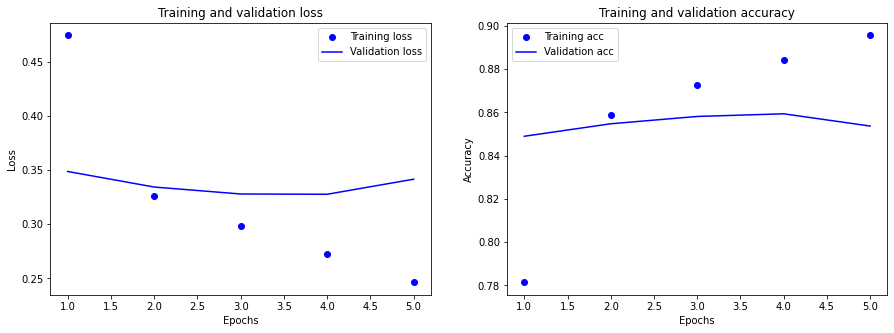

In [115]:
history_01_dict = history_model01.history

acc = history_01_dict['accuracy']
val_acc = history_01_dict['val_accuracy']
loss = history_01_dict['loss']
val_loss = history_01_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## SentencePiece_BPE_LSTM

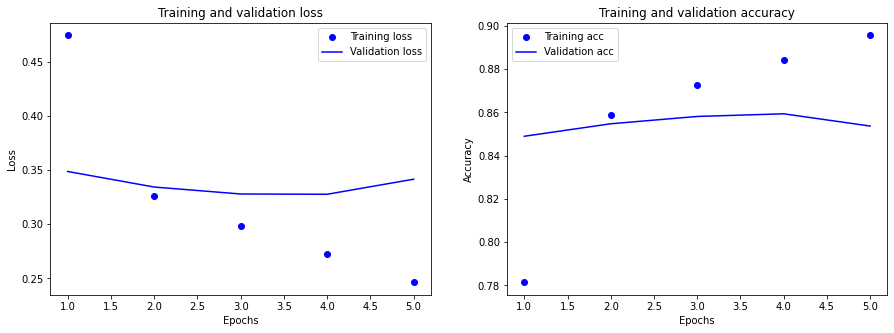

In [129]:
history_02_dict = history_model01.history

acc = history_01_dict['accuracy']
val_acc = history_01_dict['val_accuracy']
loss = history_01_dict['loss']
val_loss = history_01_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Ex_07에서 진행한 네이버 영화리뷰 감성분석 Word2Vec_LSTM
![lstm](https://user-images.githubusercontent.com/59006548/145921037-7d884ee8-14b2-4afb-8719-63f798b66044.png)
![lstm](https://user-images.githubusercontent.com/59006548/145921041-5cbff30d-6772-4eae-9dba-a578be30fdc9.png)

# 성능 비교
|모델|loss|accuracy|
|-------------|-----|-----|
|LSTM_Sentencepice_Unigram|0.3502|0.8503|
|LSTM_Sentencepice_BPE|0.3644|0.8504|
|LSTM_Word2Vec(Ex_07))|0.4247|0.8563|

# 회고
[한국어로 pretrained된 Word2Vec](https://github.com/Kyubyong/wordvectors)에 비하여 SentencePiece의 성능도 크게 뒤쳐지지 않았다!!   
SentencePiece의 범용성있는 성능이 놀라웠다 ㅇ0ㅇ 단어장 크기에 따른 성능도 해둘껄...   
SentencePiece 단어장 크기를 8000개로 둘 때, max_len을 표준편차 순으로 +1~+3(140~500즈음)까지 늘려보았지만, <pad> 토큰이 너무 많이 이어져버려서 학습이 너무 되지 않아서(accuracy 0.3 주변을 멤돔) 아예 max_len=100으로 줄여서 설정하니 그제야 제성능을 발휘하여 Word2Vec과 비슷한 성능을 내었다.   
모델 설계도 중요하긴 하나, 특히나 NLP는 토크나이징과 임베딩에서부터 제대로 처리해주지 않으면 그 결과는 천지차이임을 제대로 느끼게 해주었던 프로젝트였다